In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Figure 4

Converged. Total iteration 5000: LHS Error: 3.3482354702130124e-06; RHS Error 0.0001381199196701377
Converged. Total iteration 5000: LHS Error: 1.513931360337395e-05; RHS Error 0.00043420076279523934
Converged. Total iteration 5000: LHS Error: 2.0586199623773284e-05; RHS Error 0.0022303411098343233
Converged. Total iteration 5000: LHS Error: 1.4606629005387007e-05; RHS Error 0.0005717727581604007
Converged. Total iteration 5000: LHS Error: 2.64627053017108e-06; RHS Error 0.00013138781940240374
Converged. Total iteration 5000: LHS Error: 8.207149745720343e-06; RHS Error 0.000437112470925205
Converged. Total iteration 331: LHS Error: 9.900674768914542e-09; RHS Error 0.0022283118184663175
Converged. Total iteration 5000: LHS Error: 1.2698912591480038e-05; RHS Error 0.0008060769039047663


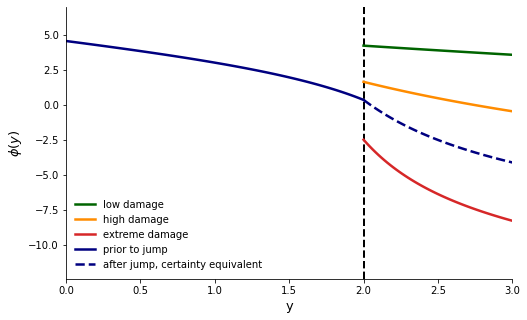

In [3]:
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Solve for value function, baseline case
model_i_baseline, model_baseline = solve_value_function(100_000., 100_000., 100_000., damage_setting)
# Sovle for value function, distorted case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting)

n_damage = len(damage_setting['πd_o'])
y_bar = model['y_grid'][-1]
y_grid_short = model['y_grid']
y_grid_long = model_i[0]['y_grid']

# Simulation
et, yt, ht, gt = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                            θ=np.mean(model['θ']), y_start=1., T=100)
et_baseline, yt_baseline, _, _ \
               = simulation(model_baseline['y_grid'], model_baseline['e_tilde'],
                            model_baseline['h'], model_baseline['g'],
                            θ=np.mean(model['θ']), y_start=1., T=100)

yt_i = []
ht_i = []
for i in range(n_damage):
    _, y_temp, h_temp, _ = simulation(y_grid_long, model_i[i]['e_tilde'], model_i[i]['h'],
                               np.zeros_like(model_i[0]['e_tilde']).reshape(1, -1), θ=np.mean(model['θ']),
                               y_start=1., T=100)    
    
    yt_i.append(y_temp)
    ht_i.append(h_temp)

# Figure 4
temp = np.array([res['v0'] for res in model_i])
certainty_equivalent = -ξ_p*np.log(np.average(np.exp(-1./ξ_p*temp), axis=0, weights=damage_setting['πd_o']))

plt.figure(figsize=(8, 5))
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[0]['v0'][y_grid_long>=y_bar],
         color='darkgreen', linewidth=2.5, label='low damage')
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[1]['v0'][y_grid_long>=y_bar],
         color='darkorange', linewidth=2.5, label='high damage')
if n_damage == 3:
    plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[2]['v0'][y_grid_long>=y_bar],
             color='tab:red', linewidth=2.5, label='extreme damage')
plt.plot(y_grid_short, model['v0'], color='navy', linewidth=2.5, label='prior to jump')
plt.plot(y_grid_long[y_grid_long>=y_bar], certainty_equivalent[y_grid_long>=y_bar],
         color='navy', linewidth=2.5, linestyle='dashed', label='after jump, certainty equivalent')
y_min = np.min(model_i[2]['v0'])*1.2
y_max = np.max(model_i[0]['v0'])*1.2
plt.vlines(2., ymin=y_min, ymax=y_max, color='black', linestyle='dashed', linewidth=2.)
plt.xlim(0, 3.)
plt.ylim(y_min, y_max)
plt.legend(frameon=False)
plt.xlabel('y', fontsize=13)
plt.ylabel(r'$\phi(y)$', fontsize=13)
plt.savefig('../plots/paper_plots/value_function.pdf')

## Figure 5

Converged. Total iteration 5000: LHS Error: 3.3482354702130124e-06; RHS Error 0.0001381199196701377
Converged. Total iteration 5000: LHS Error: 1.513931360337395e-05; RHS Error 0.00043420076279523934
Converged. Total iteration 5000: LHS Error: 2.0586199623773284e-05; RHS Error 0.0022303411098343233
Converged. Total iteration 5000: LHS Error: 1.4606629005387007e-05; RHS Error 0.0005717727581604007
Converged. Total iteration 5000: LHS Error: 2.1410878693473025e-05; RHS Error 0.00017225863881534242
Converged. Total iteration 5000: LHS Error: 1.906814142706992e-05; RHS Error 0.00043195435255777986
Converged. Total iteration 5000: LHS Error: 1.7385240946410363e-06; RHS Error 0.0022173791859049488
Converged. Total iteration 5000: LHS Error: 1.5531335336582684e-05; RHS Error 0.000798891031626954


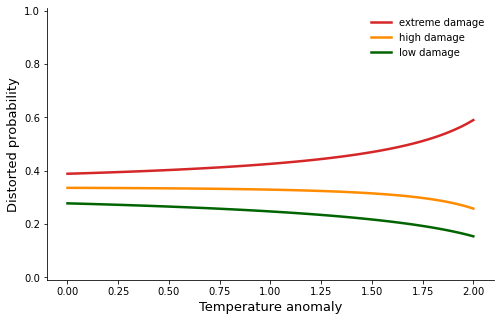

In [4]:
ξ_w = 5.
ξ_p = 5.
ξ_a = 10000.

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Solve for value function, baseline case
model_i_baseline, model_baseline = solve_value_function(100_000., 100_000., 100_000., damage_setting)
# Sovle for value function, distorted case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting)

n_damage = len(damage_setting['πd_o'])
y_bar = model['y_grid'][-1]
y_grid_short = model['y_grid']
y_grid_long = model_i[0]['y_grid']

# Simulation
et, yt, ht, gt = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                            θ=np.mean(model['θ']), y_start=1., T=100)
et_baseline, yt_baseline, _, _ \
               = simulation(model_baseline['y_grid'], model_baseline['e_tilde'],
                            model_baseline['h'], model_baseline['g'],
                            θ=np.mean(model['θ']), y_start=1., T=100)

yt_i = []
ht_i = []
for i in range(n_damage):
    _, y_temp, h_temp, _ = simulation(y_grid_long, model_i[i]['e_tilde'], model_i[i]['h'],
                               np.zeros_like(model_i[0]['e_tilde']).reshape(1, -1), θ=np.mean(model['θ']),
                               y_start=1., T=100)    
    
    yt_i.append(y_temp)
    ht_i.append(h_temp)

# Figure 5
plt.figure(figsize=(8, 5))
if n_damage == 3:
    plt.plot(y_grid_short, model['g'][2]*damage_setting['πd_o'][2]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='tab:red', label='extreme damage', linewidth=2.5)
plt.plot(y_grid_short, model['g'][1]*damage_setting['πd_o'][1]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='darkorange', label='high damage', linewidth=2.5)
plt.plot(y_grid_short, model['g'][0]*damage_setting['πd_o'][0]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='darkgreen', label='low damage', linewidth=2.5)
plt.xlabel('Temperature anomaly', fontsize=13)
plt.ylabel('Distorted probability', fontsize=13)
plt.ylim(-.01, 1.01)
plt.legend(frameon=False)

plt.savefig('../plots/paper_plots/damage_probability.pdf')

## Figure 6 & 7

In [5]:
damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

def simulate_emission(ξ_b, ξ_p, ξ_a, damage_setting, Kt, baseline):
    η = .032
    γ_1 = 1.7675/10000
    γ_2 = .0022*2
    α = 0.115
    ioverk = 0.09

    # Sovle for value function
    model_i, model = solve_value_function(ξ_b, ξ_p, ξ_a, damage_setting)

    n_damage = len(damage_setting['πd_o'])
    y_bar = model['y_grid'][-1]
    y_grid_short = model['y_grid']
    y_grid_long = model_i[0]['y_grid']
    
    σ_y = 1.2 * np.mean(model['θ'])
    # Simulation
    et, yt, _, _ = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                              θ=np.mean(model['θ']), y_start=1., T=100,
                              σ_y=σ_y, baseline=baseline)        

    Ct0 = (α - ioverk)*Kt[0]
    logSCCt = np.log(1000) + np.log(Ct0)  - (yt*γ_1 + γ_2/2.*yt**2) - np.log(et) + np.log(η) - np.log(1-η)
    return et, logSCCt, yt

In [6]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [7]:
et_baseline, logSCCt_baseline, yt_baseline = simulate_emission(ξ_b=1000000., ξ_p=1000000., ξ_a=1000000.,
                                damage_setting=damage_setting, Kt=Kt, baseline=True)
et_baseline_bp5, logSCCt_baseline_bp5, yt_baseline_bp5 = simulate_emission(ξ_b=5., ξ_p=5., ξ_a=100000.,
                                    damage_setting=damage_setting, Kt=Kt, baseline=True)
et_baseline_b03p5, logSCCt_baseline_b03p5, yt_baseline_b03p5 = simulate_emission(ξ_b=.3, ξ_p=5., ξ_a=100000.,
                                      damage_setting=damage_setting, Kt=Kt, baseline=True)
et_baseline_b03p03, logSCCt_baseline_b03p03, yt_baseline_b03p03 = simulate_emission(ξ_b=.3, ξ_p=.3, ξ_a=10000.,
                                      damage_setting=damage_setting, Kt=Kt, baseline=True)

Converged. Total iteration 5000: LHS Error: 8.393609358670062e-06; RHS Error 0.00015002700849822692
Converged. Total iteration 5000: LHS Error: 1.1132133623092955e-05; RHS Error 0.00043511534686879044
Converged. Total iteration 5000: LHS Error: 3.451568812682382e-05; RHS Error 0.002228296155794042
Converged. Total iteration 5000: LHS Error: 6.5423708754952514e-06; RHS Error 0.0005719116721159059
Converged. Total iteration 5000: LHS Error: 1.4695273501885708e-05; RHS Error 0.00012133795357981148
Converged. Total iteration 5000: LHS Error: 1.271415648425034e-05; RHS Error 0.000431230705363668
Converged. Total iteration 5000: LHS Error: 3.582962119588196e-05; RHS Error 0.0022009036681815376
Converged. Total iteration 5000: LHS Error: 1.1091026310161567e-05; RHS Error 0.0007981682201831722
Converged. Total iteration 5000: LHS Error: 4.395115867072974e-06; RHS Error 0.00011317162210058851
Converged. Total iteration 5000: LHS Error: 1.396205537904649e-05; RHS Error 0.00038757291308351427
Con

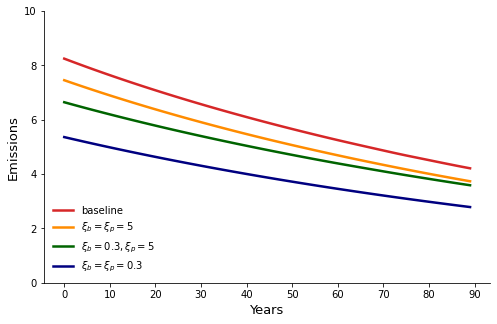

In [8]:
# Figure 6
fig = plt.figure(figsize=(8, 5))
plt.plot(et_baseline[:90], label="baseline", color="tab:red", linewidth=2.5)
plt.plot(et_baseline_bp5[:90], label="$ξ_b = ξ_p = 5$", color="darkorange", linewidth=2.5)
plt.plot(et_baseline_b03p5[:90], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen", linewidth=2.5)
plt.plot(et_baseline_b03p03[:90], label="$ξ_b = ξ_p = 0.3$" , color="navy", linewidth=2.5)

plt.legend(frameon=False, loc=3)
plt.ylim(0, 10)
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.xticks(np.arange(0, 91, 10))
plt.savefig("../plots/paper_plots/emission_three.pdf")

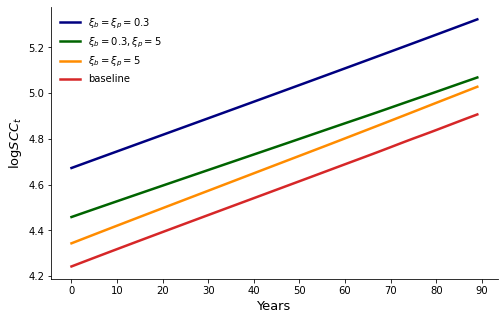

In [9]:
# Figure 7
fig = plt.figure(figsize=(8,5))

plt.plot(logSCCt_baseline_b03p03[:90], label="$ξ_b = ξ_p = 0.3$", color="navy", linewidth=2.5)
plt.plot(logSCCt_baseline_b03p5[:90], label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", linewidth=2.5)
plt.plot(logSCCt_baseline_bp5[:90], label="$ξ_b = ξ_p = 5$", color="darkorange", linewidth=2.5)
plt.plot(logSCCt_baseline[:90], label="baseline", color="tab:red", linewidth=2.5)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.xticks(np.arange(0, 91, 10))
plt.savefig("../plots/paper_plots/logscc.pdf")

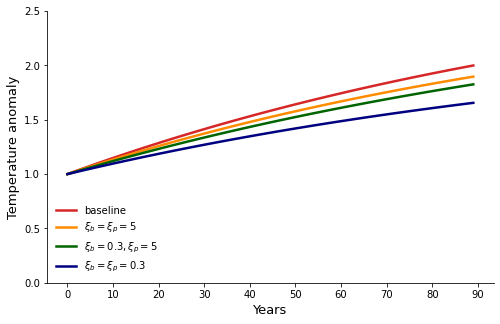

In [17]:
# Mike's request, temperature change

# Figure 6
fig = plt.figure(figsize=(8, 5))
plt.plot(yt_baseline[:90], label="baseline", color="tab:red", linewidth=2.5)
plt.plot(yt_baseline_bp5[:90], label="$ξ_b = ξ_p = 5$", color="darkorange", linewidth=2.5)
plt.plot(yt_baseline_b03p5[:90], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen", linewidth=2.5)
plt.plot(yt_baseline_b03p03[:90], label="$ξ_b = ξ_p = 0.3$" , color="navy", linewidth=2.5)

plt.legend(frameon=False, loc=3)
plt.ylim(0, 2.5)
plt.ylabel('Temperature anomaly', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.xticks(np.arange(0, 91, 10))
plt.savefig("../plots/paper_plots/temperature_three.pdf")

## Figure 8

In [11]:
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Sovle for value function, distorted case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting)

y_grid_short = model['y_grid']

Converged. Total iteration 5000: LHS Error: 2.64627053017108e-06; RHS Error 0.00013138781940240374
Converged. Total iteration 5000: LHS Error: 8.207149745720343e-06; RHS Error 0.000437112470925205
Converged. Total iteration 331: LHS Error: 9.900674768914542e-09; RHS Error 0.0022283118184663175
Converged. Total iteration 5000: LHS Error: 1.2698912591480038e-05; RHS Error 0.0008060769039047663


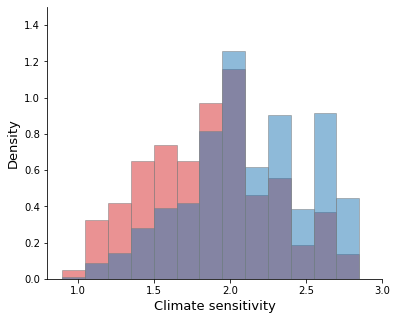

In [12]:
T_mid = 50
loc_mid = find_nearest_value(y_grid_short, yt[T_mid])

plt.figure(figsize=(6, 5))
bins = np.linspace(0., 3., 21)

plt.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
plt.hist((model['θ'])*1000, weights=model['πc'][:, loc_mid], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
plt.xlabel('Climate sensitivity', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.ylim(0,1.5)
plt.xticks(np.arange(0,3+0.5, 0.5))
plt.xlim(.8, 3)

plt.savefig('../plots/paper_plots/climate_worstcase.pdf')

## Figure 9

In [30]:
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (carbon)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb = np.array(ϕ_list_short)

# Prepare ϕ_i (temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=5_000, print_all=False)

ME_total = η/model_res['e_tilde']

Converged. Total iteration 298: LHS Error: 9.933637379333505e-09; RHS Error 0.00019752150675897417
Converged. Total iteration 5000: LHS Error: 2.0188310846158685e-06; RHS Error 0.0008578625949139732
Converged. Total iteration 5000: LHS Error: 1.450603754147295e-05; RHS Error 0.004171072504682929
Converged. Total iteration 300: LHS Error: 9.779281562316555e-09; RHS Error 0.00019371703916835903
Converged. Total iteration 5000: LHS Error: 4.963386732104169e-06; RHS Error 0.0008593804947044717
Converged. Total iteration 331: LHS Error: 9.624423924492476e-09; RHS Error 0.004201988030317299
Converged. Total iteration 299: LHS Error: 9.746443474512035e-09; RHS Error 0.00019231992100197937
Converged. Total iteration 5000: LHS Error: 5.942267405245616e-06; RHS Error 0.0008581120394292041
Converged. Total iteration 331: LHS Error: 9.744752205165241e-09; RHS Error 0.004224429027748081
Converged. Total iteration 300: LHS Error: 9.764838537762444e-09; RHS Error 0.0002447092470656276
Converged. Tota

In [31]:
# Solve temperature & carbon uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_carb = model_res_new['ME']

# Solve temperature, carbon and damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=None,
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_total_check = model_res_new['ME']

# Solve temperature uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp = model_res_new['ME']

# Solve carbon uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb = model_res_new['ME']

# Solve damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_damage = model_res_new['ME']

# Solve temperature uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_damage = model_res_new['ME']

# Solve carbon uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb_damage = model_res_new['ME']


# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

Converged. Total iteration 316: LHS Error: 7.405665591875277e-09; RHS Error 0.0007585614539855866
Converged. Total iteration 136: LHS Error: 9.179413851256867e-09; RHS Error 0.0015596824654238416
Converged. Total iteration 84: LHS Error: 9.647221865805022e-09; RHS Error 0.0006996650422957489
Converged. Total iteration 85: LHS Error: 9.822930380209982e-09; RHS Error 0.0006124896551735239
Converged. Total iteration 440: LHS Error: 8.459889100365103e-09; RHS Error 0.001382544041524554
Converged. Total iteration 10000: LHS Error: 1.7677754478029327e-07; RHS Error 0.0015080152073170018
Converged. Total iteration 174: LHS Error: 9.874218509509091e-09; RHS Error 0.0014350733160467255
Converged. Total iteration 511: LHS Error: 8.773054638311351e-09; RHS Error 0.000554238380163101


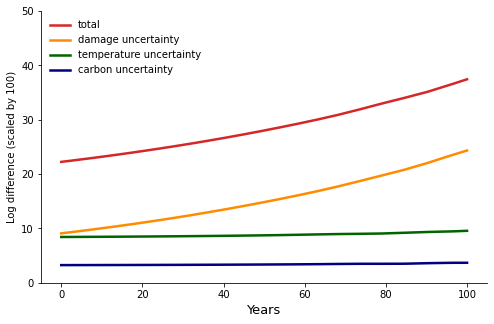

In [32]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t


plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 50)
plt.savefig('../plots/paper_plots/uncertainty_one_partition.pdf')

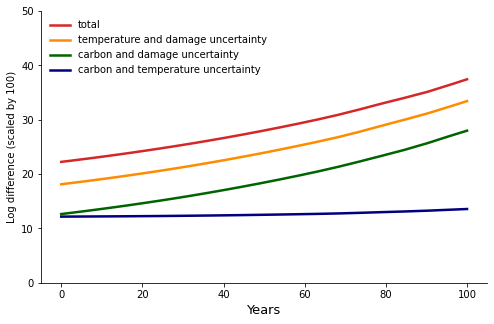

In [33]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(temp_damage_t, label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(carb_damage_t, label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_t, label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 50)
plt.savefig('../plots/paper_plots/uncertainty_two_partition.pdf')

## Figure 10

In [34]:
ξ_w = 100000.
ξ_p = .3
ξ_a = 1./100

ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (carbon)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb = np.array(ϕ_list_short)

# Prepare ϕ_i (temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=5_000, print_all=False)

ME_total = η/model_res['e_tilde']

Converged. Total iteration 298: LHS Error: 9.933637379333505e-09; RHS Error 0.00019752150675897417
Converged. Total iteration 5000: LHS Error: 2.0188310846158685e-06; RHS Error 0.0008578625949139732
Converged. Total iteration 5000: LHS Error: 1.450603754147295e-05; RHS Error 0.004171072504682929
Converged. Total iteration 300: LHS Error: 9.779281562316555e-09; RHS Error 0.00019371703916835903
Converged. Total iteration 5000: LHS Error: 4.963386732104169e-06; RHS Error 0.0008593804947044717
Converged. Total iteration 331: LHS Error: 9.624423924492476e-09; RHS Error 0.004201988030317299
Converged. Total iteration 299: LHS Error: 9.746443474512035e-09; RHS Error 0.00019231992100197937
Converged. Total iteration 5000: LHS Error: 5.942267405245616e-06; RHS Error 0.0008581120394292041
Converged. Total iteration 331: LHS Error: 9.744752205165241e-09; RHS Error 0.004224429027748081
Converged. Total iteration 300: LHS Error: 9.764838537762444e-09; RHS Error 0.0002447092470656276
Converged. Tota

In [35]:
# Solve temperature & carbon uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_carb = model_res_new['ME']

# Solve temperature, carbon and damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=None,
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_total_check = model_res_new['ME']

# Solve temperature uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp = model_res_new['ME']

# Solve carbon uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb = model_res_new['ME']

# Solve damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_damage = model_res_new['ME']

# Solve temperature uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_damage = model_res_new['ME']

# Solve carbon uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb_damage = model_res_new['ME']


# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

Converged. Total iteration 10000: LHS Error: 5.750099336365721e-06; RHS Error 0.0027083337452234145
Converged. Total iteration 10000: LHS Error: 1.2138728999011583e-05; RHS Error 0.0038226175230701466
Converged. Total iteration 10000: LHS Error: 4.390687206345945e-06; RHS Error 0.0028329410434784676
Converged. Total iteration 112: LHS Error: 8.413017837938241e-09; RHS Error 0.0030270660818145674
Converged. Total iteration 10000: LHS Error: 1.3713786843083664e-05; RHS Error 0.0034474650921268377
Converged. Total iteration 10000: LHS Error: 8.956476016885872e-06; RHS Error 0.0037085409422324637
Converged. Total iteration 111: LHS Error: 6.236478880192187e-09; RHS Error 0.0035537462296271185
Converged. Total iteration 114: LHS Error: 7.75821895615536e-09; RHS Error 0.0031457261091432133


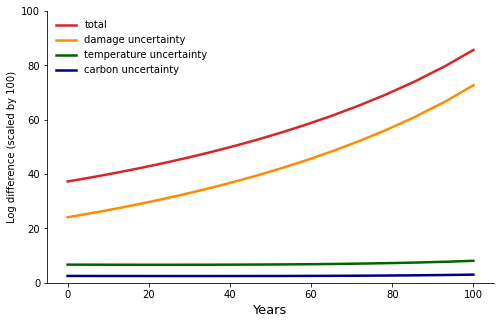

In [39]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t


plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 100)
plt.savefig('../plots/paper_plots/uncertainty_one_partition_extreme.pdf')

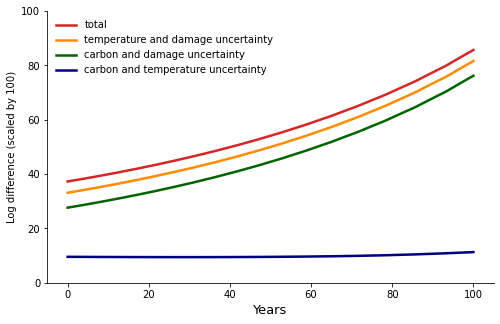

In [38]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(temp_damage_t, label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(carb_damage_t, label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_t, label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 100)
plt.savefig('../plots/paper_plots/uncertainty_two_partition_extreme.pdf')